# Zpracování spekter

In [11]:
from widgets.data import Data
import numpy as np
import scipy.interpolate as si
import matplotlib.pyplot as plt

# load
data = Data("./data/Cryptomonas.mat")

## Zekvidistantnění

!! až po odstranění spiků -> prokládání polynomem by dopadlo zle

old x axis: [ 217.21833845  220.11238693  223.0054212  ... 3845.31806325 3847.11457513
 3848.91063568], average step: 2.271227202774069
new x axis: [ 218.  219.  220. ... 3845. 3846. 3847.], average step: 1.0


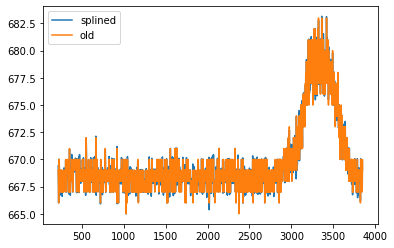

In [12]:
spectrum_spline = si.CubicSpline(data.x_axis, data.pure_data.T, extrapolate=False)
step_size = 1
new_x = np.arange(np.ceil(data.x_axis[0]), np.floor(data.x_axis[-1]), step_size)
new_data = spectrum_spline(new_x)

print(f"old x axis: {data.x_axis}, average step: {np.mean(np.abs(np.diff(data.x_axis)))}")
print(f"new x axis: {new_x}, average step: {np.mean(np.abs(np.diff(new_x)))}")

plt.plot(new_x, new_data[:,0], label='splined')
plt.plot(data.x_axis, data.pure_data[0,:], label='old')
plt.legend()
plt.show()

## Maska
Maska buňky na základě CH vibrací.

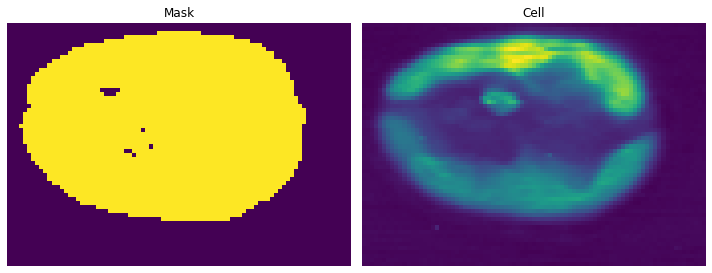

In [13]:
# normalization
threshold = 168000 # above -> cell

start = 2800
end = 3050

index_of_start = np.where(new_x==start)[0][0]
index_of_end = np.where(new_x==end)[0][0]

norm_data = new_data[index_of_start:index_of_end,:]

integral = np.sum(norm_data, axis=0) > threshold
integral = np.reshape(integral, (data.data.shape[0], data.data.shape[1]), order='F')

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
  
# showing image
plt.imshow(integral, interpolation='nearest')
plt.axis('off')
plt.title("Mask")

fig.add_subplot(1, 2, 2)

plt.imshow(data.averages, interpolation='nearest')
plt.axis('off')
plt.title("Cell")

plt.tight_layout()
plt.show()

Maska vytvořená pomocí integrálu nad lineární křivkou propojující krajní body vybraného intervalu s CH vibracemi.
Dále nutná ještě úprava pro vyplnění masky. Ideálně nejprve odstranění okolního šumu a následně vytvoření konvexního obalu.

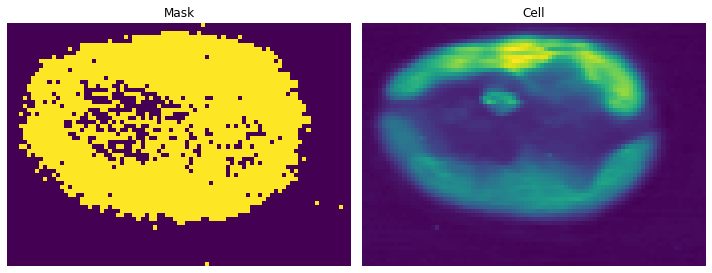

In [14]:
# normalization
threshold = 400 # above -> cell

integral = np.sum(norm_data, axis=0)
ref = ((norm_data[0,:] + norm_data[-1,:]) / 2) * norm_data.shape[0]

diff = np.reshape(integral - ref, (data.data.shape[0], data.data.shape[1]), order='F') > threshold

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
  
# showing image
plt.imshow(diff, interpolation='nearest')
plt.axis('off')
plt.title("Mask")

fig.add_subplot(1, 2, 2)

plt.imshow(data.averages, interpolation='nearest')
plt.axis('off')
plt.title("Cell")

plt.tight_layout()
plt.show()

## ICA

Rozklad na komponenty pomocí algoritmu FastICA. FastICA lze využít například i k detekci spiků nebo vytvoření masky.

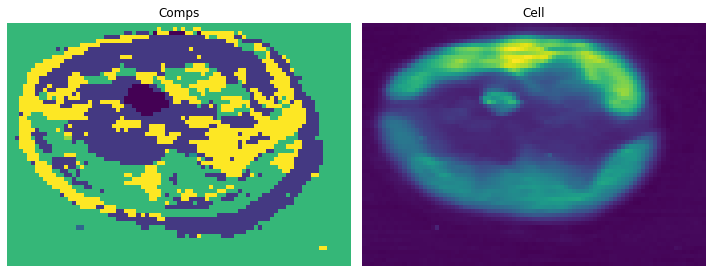

In [15]:
import sklearn.decomposition as sd

n_comp = 7
pca = sd.FastICA(n_components=n_comp)
r = pca.fit(data.pure_data).transform(data.pure_data)
r = np.argmax(np.abs(r), axis=1)

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
  
# showing image
comp_im = np.reshape(r, (data.data.shape[0], data.data.shape[1]), order='F')
plt.imshow(comp_im, interpolation='nearest')
plt.axis('off')
plt.title("Comps")

fig.add_subplot(1, 2, 2)

plt.imshow(data.averages, interpolation='nearest')
plt.axis('off')
plt.title("Cell")

plt.tight_layout()
plt.show()